# Defending a model
This notebook provides a beginner friendly introduction to using auto attack on image classification as part of Test & Evaluation of the xView dataset adapted for classification tasks. Auto attack is an ensemble or a collection of other attacks or attack configuration, which can be run in parallel. In this notebook, we learn how to instantiate the attack and deduce which attack from all is the most successful. Testing an ensemble of attacks for best performance is a crucial step in T&E.

❗**Even when applying a defenses to harden a model, the model may still be successfully attacked**❗

__Intended Audience__: All T&E users

__Requirements__: Basic Python and Torchvision / ML skills, basics of evasion attacks (Notebooks 1-3)

__Time Required__: Full run of the notebook: <2 minutes

## Contents
1. Imports
2. Load the dataset and model
3. Initial thoughts and attack set-up
4. Defense I - Gold standard: Adversarial Training
5. Defense II - Preprocessing: JPEG compression
6. Defense III - Black box and White box vulnerability: Variance minimization
7. Defense IV - Post processing: Adversarial Example detector
8. Defense V - Defensive distillation
9. Defense VI - Certified Defense
10. Conclusion
11. Next steps

## Take-aways 
- The gold standard of defenses: adversarial training
- Defenses can be applied during training, or added as pre- or postprocessing
- Defenses may affect benign performance
- The kind of attack (for example: white- vs black-box) affects defense performance

## 1. Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from typing import Tuple, Dict, Any
import os
import torch
import torchvision
from torchvision import transforms
from torch.optim import Adam
from datasets import load_dataset

# ART imports: estimator, attacks, and defenses
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.attacks.evasion import HopSkipJump
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.attacks.evasion.adversarial_patch.adversarial_patch_pytorch import AdversarialPatchPyTorch
from art.defences.preprocessor import TotalVarMin
from art.defences.postprocessor import HighConfidence
from art.defences.preprocessor import JpegCompression
from art.defences.transformer.evasion import DefensiveDistillation
from art.defences.detector.evasion import BinaryInputDetector
from art.defences.trainer import AdversarialTrainer

#HEART imports, wrappers for classifier, attacks, etc
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack
from heart_library.utils import process_inputs_for_art
from heart_library.metrics import AccuracyPerturbationMetric, HeartAccuracyMetric

from heart_library.estimators.classification.certification.derandomized_smoothing import DRSJaticPyTorchClassifier
from torchvision import transforms
from datasets import load_dataset
import torch

# command to show figures within the notebook
%matplotlib inline

## 2. Load the dataset and model
In this notebook demonstration, we are focussing on the image-classification task:
- First load an applicable dataset for classification. In this notebook we load the XView dataset for classification
- Then load a classification model. In this notebook we select a resnet18 which has been trained on XView data

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

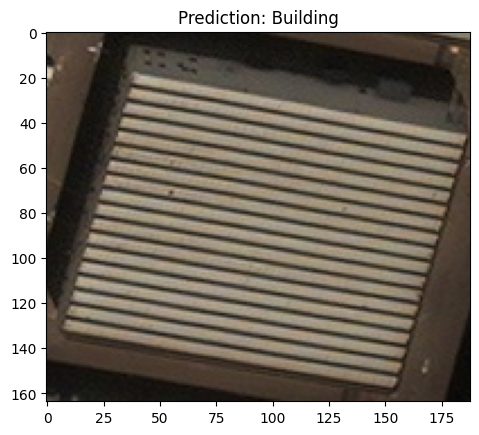

In [3]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset("CDAO/xview-subset-classification", split="test[0:12]")
idx = 3
plt.title(f"Prediction: {classes[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
#_ = model.eval()

In [4]:
'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 3. Initial thoughts and attack set-up
We define a standard white box attack and compute the performance of a model on clean and perturbed data using HEART.

When considering deploying a defense, we need to consider:
- does the application of defense negatively impact the clean accuracy?
- does the application of defense adequately positively impact robust accuracy?

In [5]:
'''
craft white box samples
'''
#Define and wrap the attacks
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

#Generate adversarial white box images
x_adv, y, metadata = attack_undefended(data=data)

'''
craft black box examples
'''
evasion_attack = HopSkipJump(classifier=jptc, max_iter=100, max_eval=100, init_eval=1, init_size=1, verbose=True)
attackbb = JaticAttack(evasion_attack)

x_advbb, ybb, metadatabb = attackbb(data=data, norm=2)

#Calc clean and robust accuracy (only on white-box)
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (undefended): {results["clean_accuracy"]}\nrobust accuracy (undefended): {results["robust_accuracy"]}')

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/12 [00:00<?, ?it/s]

clean accuracy (undefended): 0.75
robust accuracy (undefended): 0.3333333333333333


## 4. Defense I - Gold standard: Adversarial Training

We first discuss the de-facto standard defense against adversarial examples, adversarial training. This strategy consists in training on crafted attack points or adversarial examples for the model to learn to classify them correctly. To carry out adversarial training, we define a classifier and a training procedure that includes adversarial examples. We then evaluate benign and adversarial robustness of the classifier.

__Todo__: Change the parameters of the wrapped attack(s) and also of the attack that is used in training and afterwards to test the robust model.

From the result, we see that the accuracy increases on the robust model. Consider that this is *because we are overfitting on the benign data and corresponding adversarial examples we use in training.* Although adversarial training increases the robustness of the model, it does not give perfect security. We will investigate this further in the below defenses. 


In [5]:
# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get fresh classifier
model = deepcopy(model)
robust_jptc = JaticPyTorchClassifier(
    model=model, loss=torch.nn.CrossEntropyLoss(), optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=(6), clip_values=(0, 1), channels_first=False,
)

x_train, y_train, _ = process_inputs_for_art(data)
#robust_jptc.fit(x_train, y_train, nb_epochs=50)

#Define and wrap the attacks
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=robust_jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

#Generate adversarial images
x_adv, y, metadata = attack_undefended(data=data)

#Calc clean and robust accuracy
metric = AccuracyPerturbationMetric(robust_jptc(data), metadata)

metric.update(robust_jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (undefended): {results["clean_accuracy"]}\nrobust accuracy (undefended): {results["robust_accuracy"]}')

attacks = ProjectedGradientDescent(robust_jptc, eps=0.3, eps_step=0.01, max_iter=10)
trainer = AdversarialTrainer(robust_jptc, attacks, ratio=1.0)
trainer.fit(x_train, np.array(y_train), nb_epochs=20, batch_size=32)

#Calc clean and robust accuracy
metric = AccuracyPerturbationMetric(robust_jptc(data), metadata)
metric.update(robust_jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

'''
recraft samples on the robust classifer
'''
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=robust_jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

#Generate adversarial images
x_adv, y, metadata = attack_undefended(data=data)

#Calc clean and robust accuracy
metric = AccuracyPerturbationMetric(robust_jptc(data), metadata)
metric.update(robust_jptc(x_adv), y)
results = metric.compute()
print('Recraft Attacks on robust model.')
print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

clean accuracy (undefended): 0.75
robust accuracy (undefended): 0.3333333333333333


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

clean accuracy (defended): 0.75
robust accuracy (defended): 0.5833333333333334


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recraft Attacks on robust model.
clean accuracy (defended): 0.75
robust accuracy (defended): 0.3333333333333333


## 5. Defense II - Preprocessing: JPEG compression

Other mitgation or defense strategies may be applied outside the training phase. We now discuss JPEG compression, which when applied to an adversarial example may remove some of the changes introduced. Hence, the compression is applies before the sample is shown to the algorith, hence called __preprocessing__. As before, we  assess the clean and robust accuracy of the defended model, e.g. the performance on clean and perturbed data.

__Todo__: play with the quality parameter of the _JpegCompression_, this determines how much to modify the image during preprocessing. A quality of 95 will make little changes to the image, but at the risk of providing very little defense, while a quality of 1 will make larger changes to the image during preprocessing, but at the risk of decreasing the performance of clean accuracy. In this instance, when the quality is set to 1, the clean accuracy decreases from 0.75 and when the quality is set to 95 the robust accuracy decreases. 

When rerunning this notebook with your own parameters, the goal is to increase the robust accuracy compared to the previous cell (possibly at the expense of benign performance).

In [6]:
# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get fresh classifier
model = deepcopy(model)
jptc_defended = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=(6), clip_values=(0, 1), channels_first=False,
)

'''
Define the method of defense
'''
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=50
                                        )
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1), 
    preprocessing_defences=[preprocessing_defense]
)

#Define and wrap the attack
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

#Generate adversarial images
x_adv, y, metadata = attack_undefended(data=data)

#Calc clean and robust accuracy
metric = AccuracyPerturbationMetric(jptc_defended(data), metadata)
metric.update(jptc_defended(x_adv), y)
results = metric.compute()

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

clean accuracy (defended): 0.5833333333333334
robust accuracy (defended): 0.5833333333333334


## 6. Defense III - Black box and White box vulnerability: Variance minimization

To investigate the effect of different attacks on a defense, we now apply a white- and a black box-attack to the variance minimiation pre-processing defense. Similar to the JPEG compression defense, this method relies on samples and reconstructing an image from fewwer values, and is thus liekly to remove at least part of the introduced perturabtion. 

__Todo__: play with the parameters of both attack and the defense and investigate how this affects the performance of the variance minimization defense.

When rerunning this notebook with your own parameters, the goal is to observe potential differences in the attack success and defense performance comapred to the previous apporach.

In [7]:
# Get fresh model
model = deepcopy(model)

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

preprocessing_defense = TotalVarMin(clip_values=(0,1), max_iter=20)
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
    preprocessing_defences=[preprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.5833333333333334
robust accuracy (defended): 0.6666666666666666


These numbers depict the success of a white-box attack crafted in the previous cells. For comparison, we will load the same baseline model and use HopSkipJump, a black-box attack, and compare the achieved performance by the defense.

In [8]:
'''
Calc clean and robust accuracy on black box attack
'''
metric.update(jptc_defended(x_advbb), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.5833333333333334
robust accuracy (defended): 0.5


## 7. Defense IV - Post processing: Adversarial Example detector

After having seen adversarial training and pre-processing defenses, we would like to point out that there is also the possibility to detect adversarial defenses. Implementing post-processing defenses within HEART, to be compliant with MAITE, is similar to that of the pre-processing defenses. A postprocessing defense is first defined, then added as a parameter, ```postprocessing_defenses```, within the ```MAITE``` compliant ```JaticPyTorchClassifier```. The idea behind the defense shown here is to detect adversarial examples.

__Todo__: Play with the parameters of the defense to invstigate how they affect the robust accuracy.

❗ If adversarial samples are detected, they are not passed for evaluation. If all adversarial images are detected, a robust accuracy of 1 is displayed.

In [6]:
'''
Sample basic classifier to act as detector
'''
def get_simple_classifier():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # 75x75x16
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2), # 48400
        torch.nn.Flatten(),
        torch.nn.Linear(48400, 2), # 2 classes (binary classification)
    )
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    classifier = PyTorchClassifier(
        model,
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 224, 224),
        nb_classes=2,
    )
    return classifier

'''
Define and wrap the attacks
'''
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=5, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack_undefended(data=data)

# Compile training data for detector:
x_train, _, _ = process_inputs_for_art(data)
x_train_detector = np.concatenate((x_train, np.stack(x_adv)), axis=0)
y_train_detector = np.concatenate((np.array([[1, 0]] * len(x_train)), np.array([[0, 1]] * len(x_adv))), axis=0)

# Create a simple CNN for the detector
detector_classifier = get_simple_classifier()

detector = BinaryInputDetector(detector_classifier)
detector.fit(x_train_detector, y_train_detector, nb_epochs=200, batch_size=128)

# Apply detector on clean and adversarial test data:
_, test_detection = detector.detect(x_train)
_, test_adv_detection = detector.detect(np.stack(x_adv))
_, test_adv_detectionbb = detector.detect(np.stack(x_advbb))

print('Percentage of benign samples detected as adversarial:', test_detection.mean())
print('Percentage of adversarial samples detected as adversarial:', test_adv_detection.mean())
print('Percentage of black-box adversarial samples detected as adversarial:', test_adv_detectionbb.mean())

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Percentage of benign samples detected as adversarial: 0.0
Percentage of adversarial samples detected as adversarial: 1.0
Percentage of black-box adversarial samples detected as adversarial: 0.25


## 8. Defense V - Defensive distillation

Another possibility to defend white-box attacks (or mask the gradients) is defensive distillation. This defense, by changing a temperature parameter in the sigmoid output, changes the output surface. This makes it more difficult to craft white-box examples, and may affect classification of existing points. 

As this defense affects the sigmoid output, we first define a new class of model that contains a sigmoid for classifcation output. We then apply the defense and evaluate it using the previously crafted adversarial examples, both white- and black-box.

In [7]:
#Define the model, adding a Softmax layer as this defence must have probability outputs
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
model.fc = torch.nn.Sequential(
    model.fc,
    torch.nn.Softmax()
)

jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
jptc_defended = JaticPyTorchClassifier(
    model=deepcopy(model), loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1), optimizer=optimizer,
)

# Create defensive distillation transformer
transformer = DefensiveDistillation(classifier=jptc)

x_train, _, _ = process_inputs_for_art(data)
jptc_defended = transformer(x=x_train, transformed_classifier=jptc_defended)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc_defended(data), metadata)
metric.update(jptc_defended(x_adv), y)
results = metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_advbb), y)
results = metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


clean accuracy (defended): 0.8333333333333334
robust accuracy (defended): 0.4166666666666667
clean accuracy (defended): 0.75
robust accuracy (defended): 0.5


## 9. Defense VI - Certified Defense

Certification of an AI model formally guarantees a level of robustness within a determined perturbation range. Unlike the previous defenses, which could be thought of as a mitigating strategy that _may_ be effective against an adversarial attack, the certification defense provides a verfiable guarantee that, given an attack remains within a certain perturbation range, the model will maintain a (caclulated) level of robustness against __all adversarial attacks within that range__. 


The following cells demonstrate how to deploy this defense. 

> Note: this defense requires model retraining and is effective only on Vision Transformer models for now.

In [9]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = load_dataset("CDAO/xview-subset-classification", split="train")
train_data = train_data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})

cjptc = DRSJaticPyTorchClassifier(model='vit_small_patch16_224',
                                        loss=torch.nn.CrossEntropyLoss(), # loss function to use
                                        optimizer=torch.optim.Adam, # the optimizer to use: note! this is not initialised here we just supply the class!
                                        optimizer_params={"lr": 1e-4}, # the parameters to use
                                        input_shape=(3, 224, 224), # the input shape of the data: Note! that if this is a different shape to what the ViT expects it will be re-scaled
                                        nb_classes=10,
                                        clip_values=(0, 1),
                                        ablation_size=50, # Size of the retained column
                                        replace_last_layer=True, # Replace the last layer with a new set of weights to fine tune on new data
                                        load_pretrained=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(cjptc.optimizer, milestones=[20, 40], gamma=0.1)
cjptc.apply_defense(training_data=train_data, verbose=True, nb_epochs=60, 
                    update_batchnorm=True, scheduler=scheduler, transform=transforms.Compose([transforms.RandomHorizontalFlip()]))

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 60/60 [00:05<00:00, 11.17it/s]


Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Adversarial Patch PyTorch:   0%|          | 0/1000 [00:00<?, ?it/s]

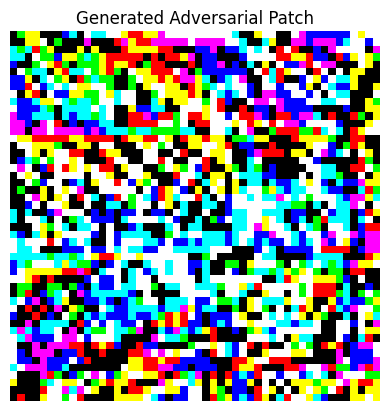

In [13]:
test_data = load_dataset("CDAO/xview-subset-classification", split="test[5:15]")
test_data = test_data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})

batch_size = 16
scale_min = 0.3
scale_max = 1.0
rotation_max = 0
learning_rate = 5000.
max_iter = 1000
patch_shape = (3, 50, 50)
patch_location = (50, 50)

ap = JaticAttack(AdversarialPatchPyTorch(estimator=cjptc, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, patch_type='square',
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, verbose=True, targeted=False))

patched_images, _, metadata = ap(data=test_data)
patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()

The following cell demonstrates the robustness of the model with the certified defense applied. The model enjoys __~89% accuracy__. The same model, without the defense applied and _under an untargeted adversarial patch attack acrues only 30% accuracy on the same dataset_. 

Inference is executed in the same way as with all MAITE compliant models.

{'accuracy': 0.8999999761581421}


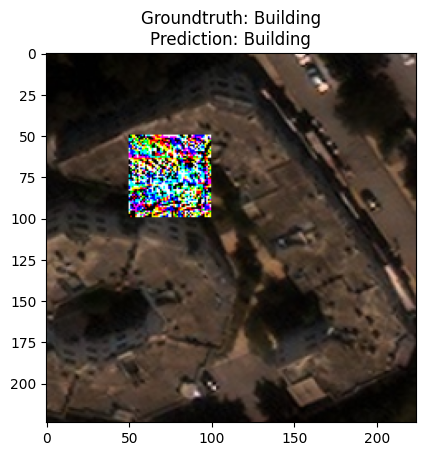

In [14]:
preds = cjptc(patched_images)

acc = HeartAccuracyMetric(task="multiclass", num_classes=10, average='micro')
acc.update(preds, test_data['label'])
print(acc.compute())

for i, patched_image in enumerate(patched_images[:1]):
    _ = plt.title(f'''Groundtruth: {classes[test_data[i]["label"]]}\nPrediction: {classes[np.argmax(preds[i])]}''')
    plt.imshow(patched_image.transpose(1,2,0))
    plt.show()

## 10. Conclusion
We have successfully aplied several defenses, including the gold standard of defenses, adversarial training. We learned that defenses can be applied at different points around the model, that they may affect benign accuracy, and that their performance depends on the applied attacks. Finally, we learned that also defended models are still vulnerable. In the next steps, we will learn how to exchange datasets to perform evaluations on non xView data.

## 11. Next steps
The final how-to guide highlights some miscellaneous tips useful when using HEART
- [5. How to Replace Datasets in Model Evaluation](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/5_How_to_Replace_Datasets_in_Model_Evaluation.ipynb)

or take a refresher on our past how-to guides:
- [1. How to Simulate White-box Attacks for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/1_How_to_Simulate_White-box_attacks_for_Image_Classification.ipynb)
- [2. How to Simulate Black-box Attacks for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/2_How_to_Simulate_Black-Box_Attacks_for_Image_Classification.ipynb)
- [3. How to Simulate Auto Attack for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/3_How_to_Simulate_Auto_Attack_for_Image_Classification.ipynb)
